In [60]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import imageio
%load_ext autoreload
%autoreload 2

import seaborn as sns
from matplotlib import rcParams

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Import connectivity graph and permutation related functions.

In [61]:
from spatial_tools.graph.build import spatial_connectivity
from spatial_tools.graph.nhood import permtest_leiden_pairs

###  Useful plotting functions

In [71]:
def plot_zscores(df, title='title', shape=[1, 2],
                 loc1=[0, 0], loc2=[0, 1]):
    hm = df.pivot('leiden.i', 'leiden.j', 'z.score')
    annot = df.pivot('leiden.i', 'leiden.j', 'n.obs')

    plt.subplot2grid(shape, loc1, rowspan=1, colspan=1)
    plt.hist(np.array(hm).flatten(), bins=100);
    plt.xlabel('z-score')
    plt.ylabel('density')

    vmax = max(hm.max())
    vmin = -5 # vmax
    # print(vmin, vmax)
    idx = hm.index.astype(int).sort_values().astype(int)
    # print(idx)

    plt.subplot2grid(shape, loc2, rowspan=1, colspan=1)
    sns.heatmap(hm.reindex([i for i in idx if i in hm.index])[[i for i in idx if i in hm]].transpose(),
                annot=annot.reindex([i for i in idx if i in hm.index])[[i for i in idx if i in hm]].transpose(),
                fmt='.0f',
                cmap='Reds', vmin=0, vmax=vmax,
                cbar_kws={'label': 'Z-score'},
                annot_kws={'fontsize': 5}, xticklabels=True, yticklabels=True)
    plt.title('Co-enrichment of pairs in connectivity graph (%s)' % (title))
    plt.tight_layout()
    
def plot_nodes_heatmap(results, vmax=None):
    hm = results.pivot('leiden.i', 'leiden.j', 'z.score')
    vmax = vmax if vmax is None else max(hm.max())
    annot = nodes.pivot('leiden.i', 'leiden.j', 'n.obs')
    g = sns.clustermap(hm.fillna(0),
                       cmap='Reds', vmin=0, vmax=vmax, cbar_kws={'label': 'Z-score'})
    plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)
    plt.tight_layout()
    plt.subplots_adjust(right=.5, bottom=.7)
    
def plot_permtest_complex(res):
    rcParams['figure.figsize'] = [15, 5]
    rcParams['figure.dpi'] = 100
    pi = 0
    colors_top = ["#e41a1c", "#377eb8", "#4daf4a", "#984ea3", "#ff7f00", "#ffff33", "#a65628"]
    for mode, grp in res.groupby('mode'):
        plt.subplot(1, 3, pi + 1)
        max_by_k = grp.sort_values('z.score', ascending=False).drop_duplicates('k').set_index('k')['z.score'].to_dict()
        color_by_k = grp.sort_values('z.score', ascending=False).drop_duplicates('k').head(len(colors_top)).set_index('k')
        color_by_k['color'] = colors_top
        color_by_k = color_by_k['color'].to_dict()
        for k, grp2 in grp.groupby(['k']):
            n_perm = list(set(grp2['n.perm']))[0]
            # print(k, sel.shape)
            plt.plot(grp2['n.degree'], grp2['z.score'], c=color_by_k[k] if k in color_by_k else 'gray',
                    label=k if k in color_by_k else '',
                    lw=2.0 if k in color_by_k else .1);
            plt.xlabel('connectivity degree')
            plt.ylabel('Z-score');
            plt.title('by %s' % mode)
            plt.legend();
        plt.ylim([-5, 100])
        pi += 1

In [63]:
# path to "raw" dataset folder
BASE_PATH = "/storage/groups/ml01/datasets/raw/20200909_PublicVisium_giovanni.palla"
dataset_name = "V1_Adult_Mouse_Brain"
dataset_folder = os.path.join(
    BASE_PATH, "20191205_10XVisium_MouseBrainCoronal_giovanni.palla"
)
adata = sc.read_visium(
    dataset_folder, count_file=f"{dataset_name}_filtered_feature_bc_matrix.h5"
)
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/icb/ignacio.ibarra/miniconda3/envs/mypython3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Pre-processing to ensure data be ready for permutations functions

In [64]:
sc.pp.neighbors(adata)
sc.tl.leiden(adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


## Big test (10x visium data)

In [65]:
from spatial_tools.graph.build import spatial_connectivity
from spatial_tools.graph.nhood import _count_observations_by_pairs
from spatial_tools.graph.nhood import *

In [66]:
spatial_connectivity(adata, n_degree=3)
conn = adata.obsp['spatial_connectivity']

leiden = adata.obs['leiden']
N = adata.shape[0]
positions = np.arange(N) # .reshape(w, h)

/home/icb/ignacio.ibarra/miniconda3/envs/mypython3/lib/python3.7/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


This is for profiling the speed of functions and speeding up. Uncomment for checking

In [67]:
# %load_ext line_profiler

# %lprun -f permtest_leiden_pairs permtest_leiden_pairs(adata, n_permutations=10, count_option='edges')
# %lprun -f permtest_leiden_pairs permtest_leiden_pairs(adata, n_permutations=100, print_log_each=25)
# %lprun -f _count_observations_by_pairs _count_observations_by_pairs(conn, leiden, positions, count_option='nodes')

Calling the permutation function.

In [68]:
n_permutations = 100

In [69]:
permtest_leiden_pairs(adata, count_option='edges',
                              print_log_each=25, n_permutations=n_permutations)
edges = adata.uns['nhood_permtest'].copy()

calculating pairwise enrichment/depletion on real data...
calculating pairwise enrichment/depletion permutations (n=100)...
Please consider a high permutation value for reliable Z-score estimates (>500)...
25 permutations (out of 100)...
50 permutations (out of 100)...
75 permutations (out of 100)...
100 permutations (out of 100)...
(171, 10)
(342, 11)


NameError: name 'lab' is not defined

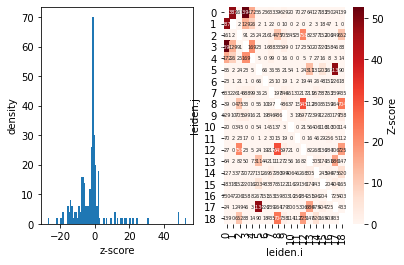

In [75]:
plot_zscores(edges, title='edges')

In [ ]:
plot_zscores(nodes, title='nodes')

In [ ]:
plot_zscores(nodes_dev, title='nodes-dev')

### Check based on nodes clusters that seemed of interest

In [ ]:
settest = {'9', '3'}

In [ ]:
rcParams['figure.dpi'] = 75
sc.pl.spatial(adata, color = "leiden")

In [ ]:
%time permtest_leiden_pairs(adata, n_permutations=n_permutations, count_option='nodes')
nodes = adata.uns['nhood_permtest'].copy()
nodes[(nodes['k'] == '3:9') | (nodes['k'] == '9:3')]

In [ ]:
%time permtest_leiden_pairs(adata, n_permutations=n_permutations, print_log_each=25, count_option='nodes-dev')
nodes_dev = adata.uns['nhood_permtest'].copy()
nodes_dev[(nodes_dev['k'] == '3:9') | (nodes_dev['k'] == '9:3')]

In [ ]:
rcParams['figure.dpi'] = 50
rcParams['figure.figsize'] = [10, 15]
adata.obs['leiden.query'] = np.where(adata.obs['leiden'].isin(settest), adata.obs['leiden'], 'others');
sc.pl.spatial(adata, color ="leiden", groups=settest);

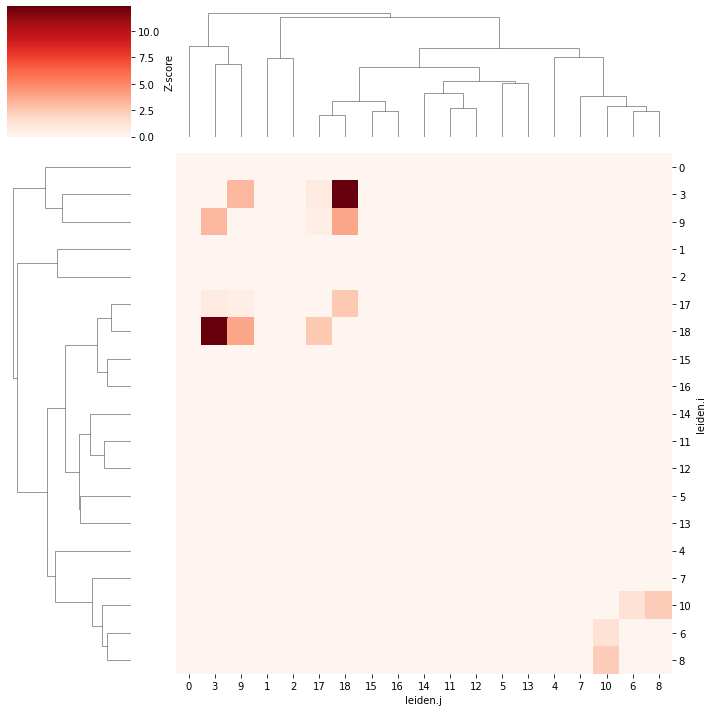

In [72]:
plot_nodes_heatmap(nodes)
plt.tight_layout()

### Permtest Z-scores for increasing connectivity values (~2 min based on parameters with 200 permutations each)

In [74]:
res = permtest_leiden_pairs_complex(adata, degree_start=1, degree_end=6, n_perm=10)

# degree 1
calculating connectivity graph with degree 1...
permutations with mode edges...
permutations with mode nodes...
permutations with mode nodes-dev...
# degree 2
calculating connectivity graph with degree 2...
permutations with mode edges...
permutations with mode nodes...
permutations with mode nodes-dev...
# degree 3
calculating connectivity graph with degree 3...
permutations with mode edges...


/home/icb/ignacio.ibarra/miniconda3/envs/mypython3/lib/python3.7/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


permutations with mode nodes...
permutations with mode nodes-dev...
# degree 4
calculating connectivity graph with degree 4...
permutations with mode edges...
permutations with mode nodes...
permutations with mode nodes-dev...
# degree 5
calculating connectivity graph with degree 5...
permutations with mode edges...


/home/icb/ignacio.ibarra/miniconda3/envs/mypython3/lib/python3.7/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


permutations with mode nodes...
permutations with mode nodes-dev...


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

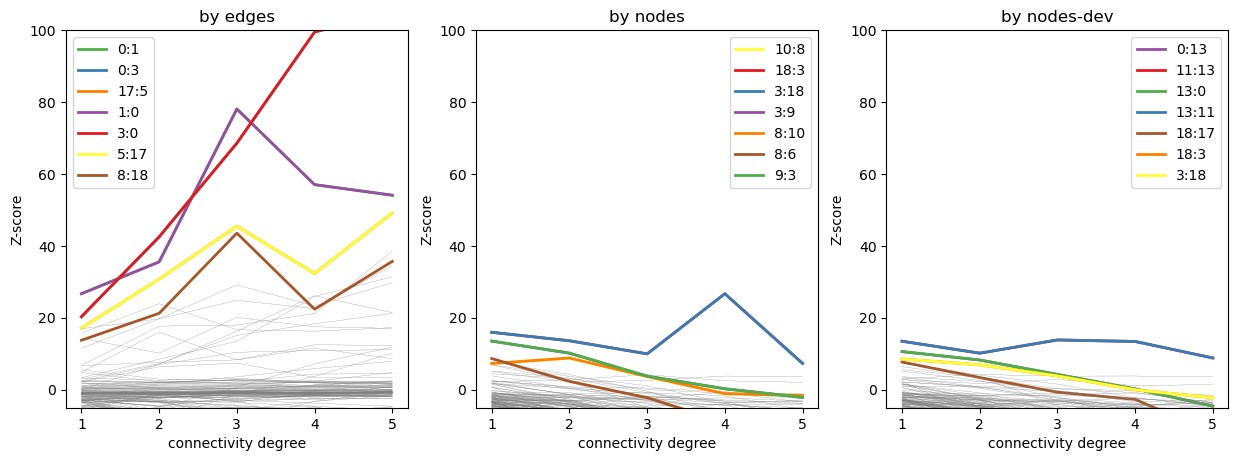

In [76]:
plot_permtest_complex(res)

## One case from nodes-dev seems not ok

/home/icb/ignacio.ibarra/miniconda3/envs/mypython3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'leiden.query' as categorical


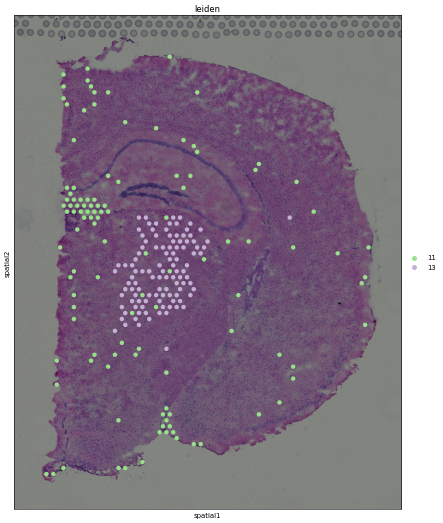

In [655]:
settest = {'11', '13'}
rcParams['figure.dpi'] = 50
rcParams['figure.figsize'] = [10, 15]
adata.obs['leiden.query'] = np.where(adata.obs['leiden'].isin(settest), adata.obs['leiden'], 'others');
sc.pl.spatial(adata, color ="leiden", groups=settest)

In [657]:
res[(res['mode'] == 'nodes')].sort_values('z.score', ascending=False).head()

,leiden.i,leiden.j,n.obs,mode,k,n.i,n.j,z.score,n.exp,sigma,n.degree,n.perm
128,18,3,129,nodes,3:18,21,220,13.655699,41.1,6.436873,2,10
128,18,3,169,nodes,3:18,21,220,12.702114,71.7,7.660142,3,10
59,9,3,237,nodes,3:9,147,220,9.570822,119.5,12.276898,1,10
59,9,3,330,nodes,3:9,147,220,9.175466,240.6,9.743374,2,10
128,18,3,77,nodes,3:18,21,220,8.594156,16.8,7.004760,1,10


## One case from mode=nodes seems ok

... storing 'leiden.query' as categorical


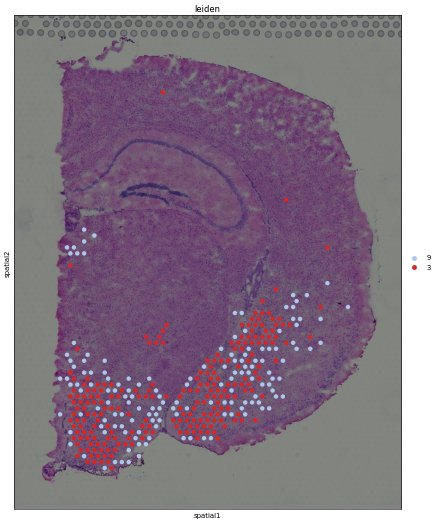

In [708]:
settest = {'3', '9'}
rcParams['figure.dpi'] = 50
rcParams['figure.figsize'] = [10, 15]
adata.obs['leiden.query'] = np.where(adata.obs['leiden'].isin(settest), adata.obs['leiden'], 'others');
sc.pl.spatial(adata, color ="leiden", groups=settest)

## One case from mode=edges seem not ok

... storing 'leiden.query' as categorical


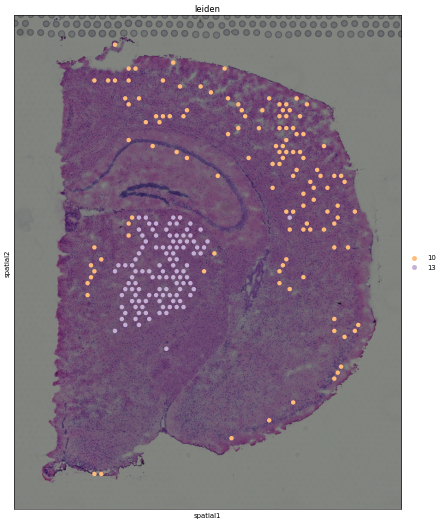

In [660]:
settest = {'10', '13'}
rcParams['figure.dpi'] = 50
rcParams['figure.figsize'] = [10, 15]
adata.obs['leiden.query'] = np.where(adata.obs['leiden'].isin(settest), adata.obs['leiden'], 'others');
sc.pl.spatial(adata, color ="leiden", groups=settest)

### Toy dataset (edges, nodes, nodes-fast)

load the data and calculate some basic metrics

In [44]:
positions = np.arange(5)
leiden = np.array([1, 1, 2, 2, 2])
conn = np.array([[0, 0, 1, 1, 1],
                 [0, 0, 1, 1, 1],
                 [1, 1, 0, 0, 0],
                 [1, 1, 0, 0, 0],
                 [1, 1, 0, 0, 0]])

print('connectivities')
print(conn)
print('leiden clusters', leiden)
print('positions in connectivity array', positions)

connectivities
[[0 0 1 1 1]
 [0 0 1 1 1]
 [1 1 0 0 0]
 [1 1 0 0 0]
 [1 1 0 0 0]]
leiden clusters [1 1 2 2 2]
positions in connectivity array [0 1 2 3 4]


Internally the main function that counts within the connectivity graph is _count_observations_by_pairs

In [45]:
from spatial_tools.graph.nhood import _count_observations_by_pairs

In [46]:
edges = _count_observations_by_pairs(conn, leiden, positions, count_option='edges')
edges.head()

,leiden.i,leiden.j,n.obs,mode,k
0,1,2,6,edges,1:2


In [47]:
nodes = _count_observations_by_pairs(conn, leiden, positions, count_option='nodes')
nodes.head()

,leiden.i,leiden.j,n.obs,mode,k
0,1,2,5,nodes,1:2


In [48]:
nodes_dev = _count_observations_by_pairs(conn, leiden, positions, count_option='nodes-dev')
nodes_dev.head()

,leiden.i,leiden.j,n.obs,mode,k
0,1,2,5,nodes-dev,1:2


When using nodes the output is as expected. The implementation based on nodes-fast returns the minimum number apparently
- This could be a minor modification somewhere
- Additionally np.meshgrid([x, y]) can be implemented for option='nodes', to avoid writing the function cartesian
    - A more detailed discussion in here
https://stackoverflow.com/questions/1208118/using-numpy-to-build-an-array-of-all-combinations-of-two-arrays

In [49]:
positions = np.arange(5)
leiden = np.array([1, 1, 2, 2, 2])
conn = np.array([[0, 0, 1, 1, 1],
                 [0, 0, 1, 1, 1],
                 [1, 1, 0, 0, 0],
                 [1, 1, 0, 0, 0],
                 [1, 1, 0, 0, 0]])

print('connectivities')
print(conn)
print('leiden', leiden)
print('positions', positions)

connectivities
[[0 0 1 1 1]
 [0 0 1 1 1]
 [1 1 0 0 0]
 [1 1 0 0 0]
 [1 1 0 0 0]]
leiden [1 1 2 2 2]
positions [0 1 2 3 4]


In [50]:
edges = _count_observations_by_pairs(conn, leiden, positions, count_option='edges')
edges.head()

,leiden.i,leiden.j,n.obs,mode,k
0,1,2,6,edges,1:2


### Issue: here the nodes-dev should throw 5 but instead it throws 3. Probably it counts only one category (tbc)

In [51]:
nodes_fast = _count_observations_by_pairs(conn, leiden, positions, count_option='nodes-dev')
nodes_fast.head()

,leiden.i,leiden.j,n.obs,mode,k
0,1,2,5,nodes-dev,1:2


In [52]:
nodes = _count_observations_by_pairs(conn, leiden, positions, count_option='nodes')
nodes.head()

,leiden.i,leiden.j,n.obs,mode,k
0,1,2,5,nodes,1:2


In [53]:
len(list(combinations(set(leiden), r=2)))

1

In [54]:
%time permtest_leiden_pairs(adata, n_permutations=n_permutations, print_log_each=10, count_option='edges')
edges = adata.uns['nhood_permtest'].copy()

calculating pairwise enrichment/depletion on real data...
calculating pairwise enrichment/depletion permutations (n=100)...
Please consider a high permutation value for reliable Z-score estimates (>500)...
10 permutations (out of 100)...
20 permutations (out of 100)...
30 permutations (out of 100)...
40 permutations (out of 100)...
50 permutations (out of 100)...
60 permutations (out of 100)...
70 permutations (out of 100)...
80 permutations (out of 100)...
90 permutations (out of 100)...
100 permutations (out of 100)...
(171, 10)
(342, 11)
CPU times: user 39.8 s, sys: 28.4 ms, total: 39.9 s
Wall time: 40.1 s


In [55]:
edges.shape
edges[(edges['k'] == '3:9') | (edges['k'] == '9:3')]

,leiden.i,leiden.j,n.obs,mode,k,n.i,n.j,z.score,n.exp,sigma,k.sorted
56,3,9,599,edges,3:9,220,147,2.487002,310.92,115.834232,3:9
56,9,3,599,edges,9:3,220,147,2.487002,310.92,115.834232,3:9


In [56]:
%time permtest_leiden_pairs(adata, n_permutations=n_permutations, print_log_each=25, count_option='nodes')
nodes = adata.uns['nhood_permtest'].copy()

calculating pairwise enrichment/depletion on real data...
calculating pairwise enrichment/depletion permutations (n=100)...
Please consider a high permutation value for reliable Z-score estimates (>500)...
25 permutations (out of 100)...
50 permutations (out of 100)...
75 permutations (out of 100)...
100 permutations (out of 100)...
(171, 10)
(342, 11)
CPU times: user 36.2 s, sys: 5.46 s, total: 41.7 s
Wall time: 42 s


In [57]:
nodes.shape
nodes[(nodes['k'] == '3:9') | (nodes['k'] == '9:3')]

,leiden.i,leiden.j,n.obs,mode,k,n.i,n.j,z.score,n.exp,sigma,k.sorted
50,9,3,349,nodes,9:3,147,220,3.195468,321.54,8.59342,3:9
50,3,9,349,nodes,3:9,147,220,3.195468,321.54,8.59342,3:9


In [58]:
%time permtest_leiden_pairs(adata, n_permutations=n_permutations, print_log_each=25, count_option='nodes-dev')
nodes_dev = adata.uns['nhood_permtest'].copy()

calculating pairwise enrichment/depletion on real data...
calculating pairwise enrichment/depletion permutations (n=100)...
Please consider a high permutation value for reliable Z-score estimates (>500)...
25 permutations (out of 100)...
50 permutations (out of 100)...
75 permutations (out of 100)...
100 permutations (out of 100)...
(171, 10)
(342, 11)
CPU times: user 41.2 s, sys: 23.5 ms, total: 41.2 s
Wall time: 41.5 s


In [59]:
nodes_dev.shape
nodes_dev[(nodes_dev['k'] == '3:9') | (nodes_dev['k'] == '9:3')]

,leiden.i,leiden.j,n.obs,mode,k,n.i,n.j,z.score,n.exp,sigma,k.sorted
56,3,9,11,nodes-dev,3:9,220,147,-6.941462,59.5,6.987001,3:9
56,9,3,11,nodes-dev,9:3,220,147,-6.941462,59.5,6.987001,3:9


### Here we check whether the association between nodes and nodes-dev makes sense

In [ ]:
rcParams['figure.dpi'] = 100
rcParams['figure.figsize'] = [5, 5]
x = nodes.set_index('k')['n.obs'].to_dict()
y = nodes_dev.set_index('k')['n.obs'].to_dict()
v = pd.DataFrame(index=x.keys())
v['nodes'] = v.index.map(x)
v['nodes.dev'] = v.index.map(y)
plt.scatter(v['nodes'], v['nodes.dev'])
plt.xlabel('# obs (nodes)')
plt.ylabel('# obs (nodes-dev)')

Currently the running time is ~15-20s / 100 permutations. Therefore
- 1000 permutations would take ~150-200 s. 
- 10k permutations would take ~1500-2000 s.

In [ ]:
rcParams['figure.dpi'] = 75
rcParams['figure.figsize'] = [10, 5]